In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import datasets
from datasets import Dataset

from transformers import AutoTokenizer, TFBertForSequenceClassification, AdamWeightDecay


## Load the data and do some basic preprocessing.

In [2]:
tweets = pd.read_csv("tweets.csv")
tweets.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [3]:

# Won't need textID?
del tweets['textID']

tweets.rename(columns = {'sentiment':'label'}, inplace = True)
tweets = tweets[['label', 'text']]

# Map emotions to ints
# 0  - > Negative
# 1  - > Neutral
# 2  - > Positive
tweets.label = tweets.label.replace(["negative"], 0)
tweets.label = tweets.label.replace(["neutral"], 1)
tweets.label = tweets.label.replace(["positive"], 2)

# Use RegEx to remove all http and https links.
tweets.text = tweets.text.replace(to_replace='https?://\S* *', regex=True, value='')

print("TOTAL tweets : ", len(tweets))

tweets.head()

TOTAL tweets :  27481


,label,text
0,1,"I`d have responded, if I were going"
1,0,Sooo SAD I will miss you here in San Diego!!!
2,0,my boss is bullying me...
3,0,what interview! leave me alone
4,0,"Sons of ****, why couldn`t they put them on t..."


In [4]:
# Check for null values
print(tweets['text'].isnull().values.any())
print(tweets['label'].isnull().values.any())

True
False


In [5]:
# Drop them
tweets = tweets.dropna()


<AxesSubplot:title={'center':'Count of emotions'}>

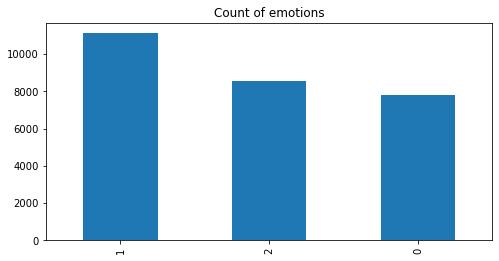

In [6]:
tweets.label.value_counts().plot(kind = 'bar', title = 'Count of emotions', figsize = (8,4))

## Create a train/val/test split (70/10/20)

In [7]:

train, rest = train_test_split(tweets, test_size=0.3, shuffle = False)
val, test = train_test_split(rest, test_size=0.66, shuffle = False)

per_cent = lambda x : len(x)*100/len(tweets)

print("Train : %.2f\nValidation : %.2f\nTest : %.2f" % (per_cent(train), per_cent(val), per_cent(test)) )

Train : 70.00
Validation : 10.20
Test : 19.80


In [8]:
# Make them Dataset objects
train = Dataset.from_pandas(train)
val = Dataset.from_pandas(val)
test = Dataset.from_pandas(test)

# May need to remove this!
train = train.remove_columns(["__index_level_0__"])
val = val.remove_columns(["__index_level_0__"])
test = test.remove_columns(["__index_level_0__"])

# Split
dataset = datasets.DatasetDict()
dataset["train"] = train
dataset["val"] = val
dataset["test"] = test

## Load the Base BERT model

In [9]:

model_checkpoint = "bert-base-uncased"

model = TFBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 3)

tokenizer  = AutoTokenizer.from_pretrained(model_checkpoint)

# May be too small!!
optimizer = AdamWeightDecay(learning_rate=4e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer, metrics=['accuracy'])
model.summary()


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


## Tokenize all the tweets.

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='longest')

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tf_dataset_train = model.prepare_tf_dataset(tokenized_dataset["train"], batch_size=8, shuffle=True, tokenizer = tokenizer)
tf_dataset_val = model.prepare_tf_dataset(tokenized_dataset["val"], batch_size=8, shuffle=True, tokenizer = tokenizer)
tf_dataset_test = model.prepare_tf_dataset(tokenized_dataset["test"], batch_size=8, shuffle=True, tokenizer = tokenizer)


  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

## Fine - Tune

In [11]:
#tf.config.run_functions_eagerly(True)
with tf.device('/GPU:0'):
    history = model.fit(x = tf_dataset_train, validation_data = tf_dataset_val, epochs=1)

2404/2404 [==============================] - 362s 143ms/step - loss: 0.6039 - accuracy: 0.7525 - val_loss: 0.5348 - val_accuracy: 0.7857


## Accuracy 78 % after 1 epoch!

In [12]:

predictions = model.evaluate(tf_dataset_test, verbose=1)


680/680 [==============================] - 26s 38ms/step - loss: 0.5409 - accuracy: 0.7792


In [13]:
#tf.config.run_functions_eagerly(True)
with tf.device('/GPU:0'):
    history2 = model.fit(x = tf_dataset_train, validation_data = tf_dataset_val, epochs=1)

2404/2404 [==============================] - 348s 145ms/step - loss: 0.4239 - accuracy: 0.8340 - val_loss: 0.5592 - val_accuracy: 0.7746


In [14]:
predictions2 = model.evaluate(tf_dataset_test, verbose=1)

680/680 [==============================] - 26s 39ms/step - loss: 0.5604 - accuracy: 0.7767


In [ ]:
#import os
#model.save_weights(os.getcwd())# 

In [ ]:
predictions = []

step = 50
for i in range(0, len(test) , step):

    batch = test['text'][i:i + step]
    tokenized = tokenizer(batch, padding=True, return_tensors='tf')
    output = model(tokenized)
    
    predicted_class_id = tf.math.argmax(output.logits, axis=-1)
    predicted_class_id = predicted_class_id.numpy().tolist()
    
    predictions += predicted_class_id
    



In [18]:
a = np.array(predictions)   # actual labels
b = np.array(test['label'])   # predicted labels

correct = (a == b)
accuracy = correct.sum() / correct.size
accuracy

0.7767364939360529

In [23]:
true = test['label']
predict = predictions
n_classes = 3

In [51]:
from sklearn.metrics import classification_report
report = classification_report(true, predict, labels=[0,1,2], target_names=["Negative", "Neutral", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78      1569
     Neutral       0.75      0.74      0.75      2246
    Positive       0.82      0.81      0.81      1627

    accuracy                           0.78      5442
   macro avg       0.78      0.78      0.78      5442
weighted avg       0.78      0.78      0.78      5442



In [82]:


cm = confusion_matrix(test['label'], predict, labels=[0,1,2])


array([[1237,  297,   35],
       [ 316, 1668,  262],
       [  57,  248, 1322]], dtype=int64)

In [83]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

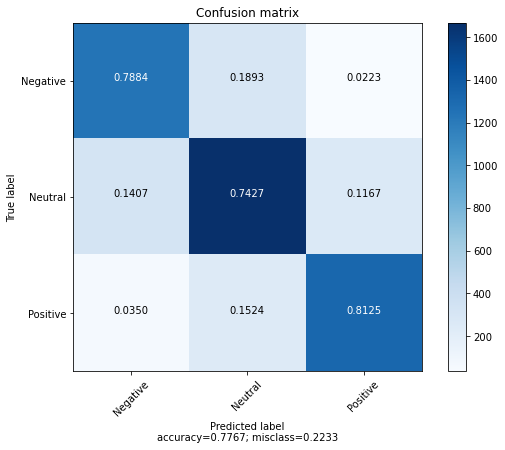

In [85]:
plot_confusion_matrix(cm, target_names=["Negative", "Neutral", "Positive"])

# As expected the models finds it hard to distinguish neutral from the other 2 emotions.
# It would perform much better if there were only 2 emotions.(bad, good)